In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.tail as exp_tail

# Explore

In [4]:
np.random.seed(2024)

In [ ]:
dim = 1
n = 10000
dof = 100

scale = jnp.sqrt((dof - 2) / dof)
Xs = np.random.standard_t(df=dof, size=(n, dim)) * scale

In [28]:
Xs.mean(), Xs.std()

(Array(0.00619668, dtype=float32), Array(1.0359316, dtype=float32))

# Load

In [71]:
n = 500
d = 1
res_stats = pickle.load(open(f"../data/tail/stats_n{n}_d{d}.pkl", "rb"))

dof_ls = list(res_stats.keys())
dof_ls

[3, 5, 10, 20, 50, 100, 200]

In [72]:
tau = pickle.load(open(f"../data/tail/tau_d{d}.pkl", "rb"))
tau

{3: Array(3.8681238, dtype=float32),
 5: Array(2.7534442, dtype=float32),
 10: Array(2.4000156, dtype=float32),
 20: Array(2.3234375, dtype=float32),
 50: Array(2.589747, dtype=float32),
 100: Array(2.2976432, dtype=float32),
 200: Array(2.3281338, dtype=float32)}

In [73]:
# change theta
eps0_ls = [0.05, 0.1, 0.25]
plot_df_ls = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for dof in dof_ls:
        theta_new = eps0 * tau[dof]**0.5
        # theta_new = eps0 * res_stats[dof]["theta"] / 0.05
        
        res_stats_new[dof] = exp_utils.change_theta(res_stats_new[dof], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}
    
    plot_df = {"dof": [], "nonsq_stat": [], "method": [], "rej": []}
    for dof in dof_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[dof][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["dof"].extend([dof] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

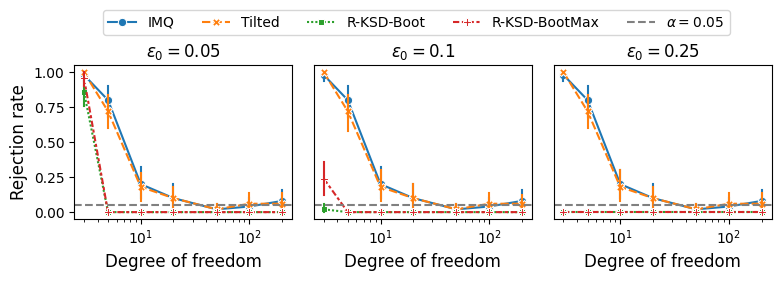

In [74]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(3*len(eps0_ls), 2))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="dof", y="rej", hue="method", style="method", markers=True, err_style="bars")
    # ax.axvline(eps0, color="k", linestyle="-.", label=r"$\epsilon_0$")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Degree of freedom", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale("log")
    ax.set_title(rf"$\epsilon_0 = ${eps0}")
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(0.1, 1.15, 1, 0.2), loc="lower left", ncol=6)

plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [160]:
from kgof import data as kgof_data
# from kgof import density as kgof_den
import src.kgof_density as kgof_den

In [ ]:
seed = 2024
key = jax.random.key(seed)
keys = jax.random.split(key, 3)

dim = 50
h_dim = 10
b = jax.random.normal(keys[0], shape=(dim,))
c = jax.random.normal(keys[1], shape=(h_dim,))
B = jax.random.bernoulli(keys[2], shape=(dim, h_dim)).astype(jnp.float32) * 2 - 1.

In [ ]:
rbm_sampler = kgof_data.DSGaussBernRBM(B, b, c)

In [ ]:
rbm_samples = rbm_sampler.sample(500).data()

In [ ]:
rbm_model = kgof_den.GaussBernRBM(B, b, c)

In [161]:
X_res = pickle.load(open("../data/rbm/X_res_seed2024.pkl", "rb"))
score_res = pickle.load(open("../data/rbm/score_res_seed2024.pkl", "rb"))

In [162]:
eps = 0.1
X = X_res[eps][0]
score = score_res[eps][0]

In [165]:
score_weight_fn = kernels.PolyWeightFunction(loc=jnp.zeros_like(X[0]))
kernel0 = kernels.RBF(med_heuristic=True, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
ksd = metrics.KSD(kernel, score_fn=rbm_model.grad_log)

In [166]:
def obj(x):
    s = ksd.score_fn(x)
    return -ksd(x, x, score=s, vstat=True)

def weighted_score(x):
    s = ksd.score_fn(x)
    w = score_weight_fn(x)
    return -jnp.sum((w * s)**2)

In [174]:
init_val = X[[0], :]
solver = jaxopt.LBFGS(fun=lambda x: exp_rbm.minus_stein_kernel(x, ksd), maxiter=2000)
opt_res = solver.run(init_val)

In [175]:
print(opt_res.state)

LbfgsState(iter_num=Array(5, dtype=int32, weak_type=True), value=Array(-0.9645757, dtype=float32), grad=Array([[ 1.5281547e-04, -7.7755976e-07,  5.1139068e-05, -3.0709041e-05,
         1.2315471e-05, -1.9021798e-05, -4.4261105e-05,  5.1556199e-05,
         2.7462220e-05, -4.7177193e-05, -4.2020465e-06, -3.9225190e-05,
         2.5478294e-06, -1.0941626e-04, -3.4177134e-05, -7.7971439e-05,
         1.3500398e-04,  1.3555521e-04, -3.1131778e-05,  2.2084350e-08,
         1.0929838e-05, -1.6963204e-05, -3.8442642e-05,  8.7619861e-05,
        -8.0437283e-05, -7.5808450e-05,  3.7933685e-05,  8.3511855e-05,
        -2.4626359e-05, -8.0194222e-06, -2.8642600e-05,  1.3100915e-05,
        -6.4510241e-05, -6.5056247e-06, -1.3459531e-04, -1.3100350e-04,
        -1.0809209e-04,  5.6102879e-05, -3.0876839e-05, -7.1857547e-05,
         7.2831444e-06,  8.9861191e-05, -6.7529894e-05, -1.2257899e-04,
        -8.5058622e-05,  1.5774436e-04,  6.3538137e-05, -5.3806853e-05,
        -7.1405753e-05,  8.75283

In [195]:
opt_res = exp_rbm.parallel_optimize(X[:10], ksd, maxiter=500)

In [198]:
jnp.max(-opt_res)

Array(127.46715, dtype=float32)

In [19]:
n = 500
res_stats = pickle.load(open(f"../data/rbm/stats_n{n}_seed2024.pkl", "rb"))

eps_ls = list(res_stats.keys())
eps_ls

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [20]:
res_stats[0.]["standard"]["stat"]

[Array(0.10474893, dtype=float32),
 Array(0.08188516, dtype=float32),
 Array(0.10604961, dtype=float32),
 Array(0.1363251, dtype=float32),
 Array(0.096512, dtype=float32),
 Array(0.10443558, dtype=float32),
 Array(0.08889903, dtype=float32),
 Array(0.09542555, dtype=float32),
 Array(0.07855024, dtype=float32),
 Array(0.09768385, dtype=float32),
 Array(0.07157553, dtype=float32),
 Array(0.08252256, dtype=float32),
 Array(0.1052311, dtype=float32),
 Array(0.10643831, dtype=float32),
 Array(0.12133214, dtype=float32),
 Array(0.11368502, dtype=float32),
 Array(0.11025629, dtype=float32),
 Array(0.11428444, dtype=float32),
 Array(0.09711432, dtype=float32),
 Array(0.09395156, dtype=float32),
 Array(0.09864882, dtype=float32),
 Array(0.12016127, dtype=float32),
 Array(0.12378664, dtype=float32),
 Array(0.08487402, dtype=float32),
 Array(0.08285072, dtype=float32),
 Array(0.10160621, dtype=float32),
 Array(0.09408417, dtype=float32),
 Array(0.11823204, dtype=float32),
 Array(0.09686102, dtype

In [21]:
tau = pickle.load(open(f"../data/rbm/tau_n{n}_seed2024.pkl", "rb"))
tau

{0.0: Array(127.43911, dtype=float32),
 0.1: Array(127.49344, dtype=float32),
 0.2: Array(127.50098, dtype=float32),
 0.3: Array(127.505516, dtype=float32),
 0.4: Array(127.5114, dtype=float32),
 0.5: Array(127.518394, dtype=float32),
 0.6: Array(127.53009, dtype=float32),
 0.7: Array(128.13385, dtype=float32),
 0.8: Array(134.37508, dtype=float32),
 0.9: Array(134.94675, dtype=float32),
 1.0: Array(135.36397, dtype=float32)}

In [48]:
# change theta
eps0_ls = [0.05, 0.1, 0.25]
plot_df_ls = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for eps in eps_ls:
        theta_new = eps0 * tau[eps]**0.5
        res_stats_new[eps] = exp_utils.change_theta(res_stats_new[eps], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}
    
    plot_df = {"eps": [], "nonsq_stat": [], "method": [], "rej": []}
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[eps][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

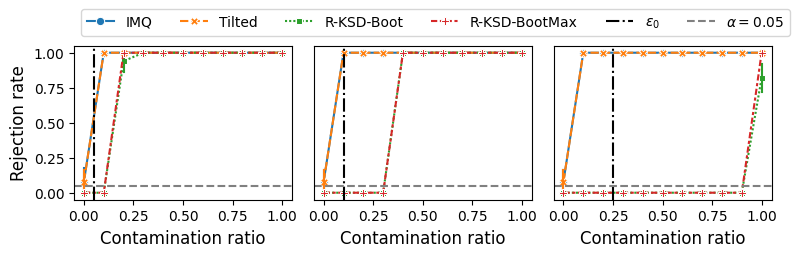

In [51]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(3*len(eps0_ls), 2))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.axvline(eps0, color="k", linestyle="-.", label=r"$\epsilon_0$")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Contamination ratio", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", ncol=6)

plt.subplots_adjust(wspace=0.1)
plt.savefig("../figs/robust/rbm.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [38]:
eps0 * tau[0.7]**0.5, eps0 * tau[0.8]**0.5

(Array(2.2639244, dtype=float32), Array(2.3184054, dtype=float32))

In [34]:
plot_df.loc[(plot_df.eps == 0.7) & (plot_df.method == "R-KSD-Boot")]

,eps,nonsq_stat,method,rej
1500,0.7,2.486996,R-KSD-Boot,1
1501,0.7,2.516096,R-KSD-Boot,1
1502,0.7,2.473825,R-KSD-Boot,1
1503,0.7,2.448104,R-KSD-Boot,1
1504,0.7,2.478103,R-KSD-Boot,1
1505,0.7,2.483013,R-KSD-Boot,1
1506,0.7,2.462764,R-KSD-Boot,1
1507,0.7,2.487513,R-KSD-Boot,1
1508,0.7,2.472959,R-KSD-Boot,1
1509,0.7,2.484827,R-KSD-Boot,1


In [229]:
X_res = pickle.load(open(f"../data/rbm/X_res_n{n}_seed2024.pkl", "rb"))
score_res = pickle.load(open(f"../data/rbm/score_res_n{n}_seed2024.pkl", "rb"))